In [11]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm

In [12]:
def plt2D(fig, ax, x, y, z, z1 = [0], cmap=cm.viridis, levels=np.linspace(0, 40, 10 + 1), 
          levels1 = [35., 40., 45.], title = '', ylabel = '', zlabel = 'Cloud Fraction (%)',
          xlabel = False, cbar = True, extend = 'both', fontsize = 12, 
          yrange = [0., 3.], xrange = [-6, 6], plotregion = False):
    
    oax = ax.contourf(x, y, z, cmap=cmap, levels=levels, extend=extend)
    
    if np.size(z1) > 1:
        CS = ax.contour(x, y, z1, levels=levels1, colors='black', linewidths=0.4)
        plt.clabel(CS, fontsize=7, inline=1, fmt='%2.0f')
        
    ax.set_xlim(xrange)
    ax.set_ylim(yrange)
    
    ax.set_ylabel(ylabel, fontsize=fontsize) 
    if xlabel:
        ax.set_xlabel('Distance from ice edge \n ($\degree$ latitude)', fontsize=fontsize) 
    
    ax.set_title(title, fontsize=fontsize)
    
    ax.axvline(x=0., color='black', lw=0.5, linestyle='--')
    
    if plotregion:
        ax.axvline(x=-2., color='grey', lw=0.5, linestyle='--')
        ax.axvline(x=2., color='grey', lw=0.5, linestyle='--')
            
    if cbar:
        cbar = fig.colorbar(oax, ax=ax, orientation='vertical', shrink=0.8, aspect=15, 
                            ticks=[levels.min(), levels.max()])
        cbar.set_label(zlabel, fontsize=0.8*fontsize)
    
    return oax

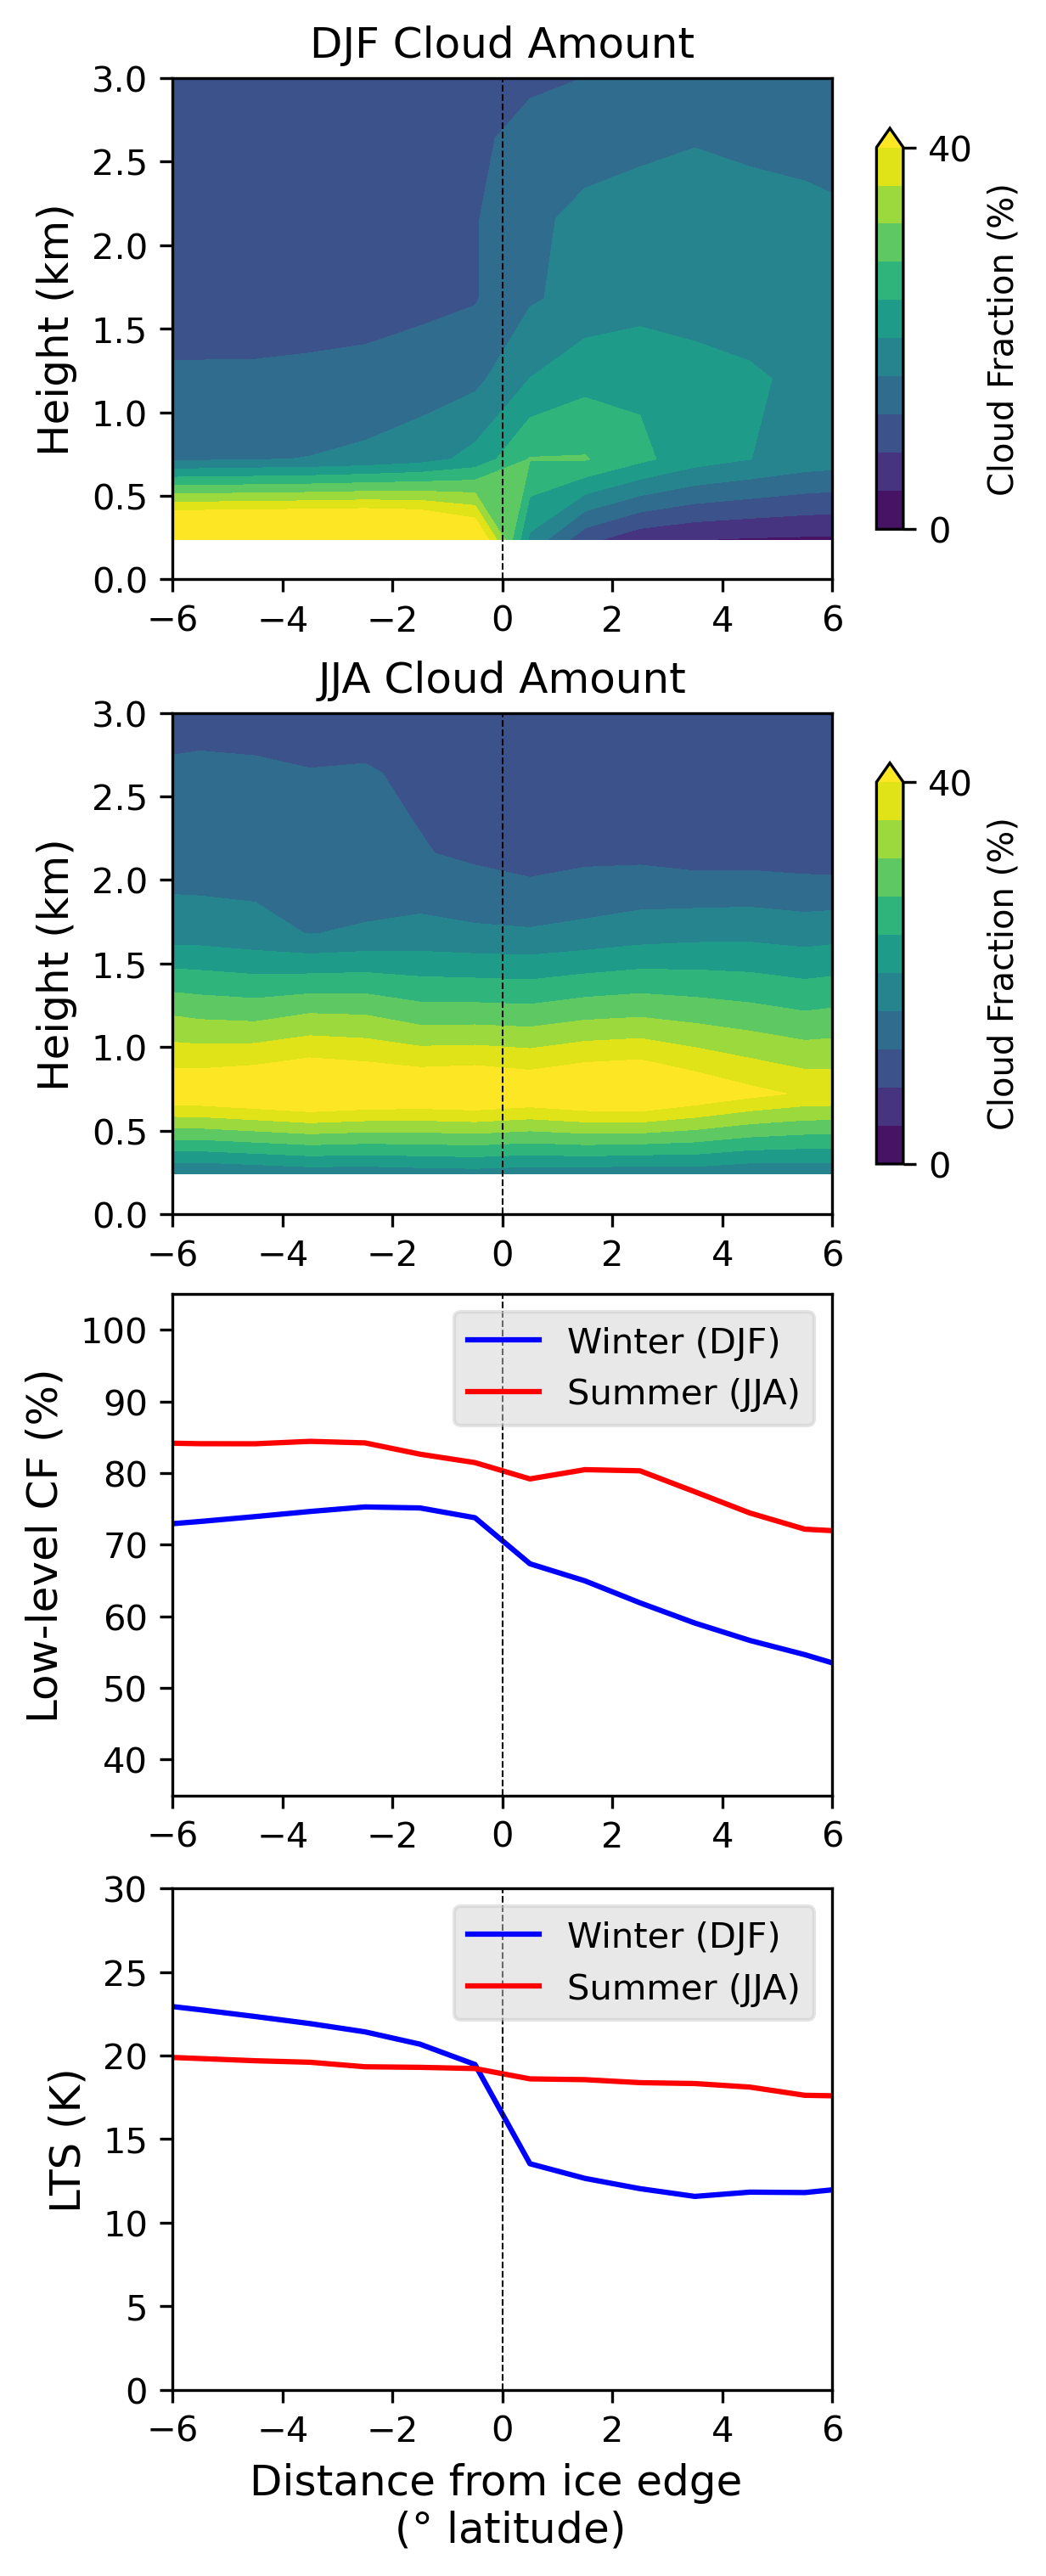

In [15]:
file_2d = "Example_Modeled_2D_Meteorology.nc"
file_3d = "Example_Modeled_3D_Meteorology.nc"

# === Open datasets and seasonal mean ===
f2 = xr.open_dataset(file_2d).groupby("time.season").mean()
f3 = xr.open_dataset(file_3d).groupby("time.season").mean()
f3["level"] = f3["level"] / 100  # Convert to hPa

# === LTS calculation ===
pres = f3.level.expand_dims(distance=f3["distance"].size).transpose().expand_dims(season=f3["season"].size)
f3["lts"] = (f3.air * (1000. / pres) ** 0.286).isel(level=3) - \
            (f3.air * (1000. / pres) ** 0.286).isel(level=0)

# === Seasonal splits ===
djf_data_2d = f2.sel(season="DJF")
jja_data_2d = f2.sel(season="JJA")
djf_data_3d = f3.sel(season="DJF")
jja_data_3d = f3.sel(season="JJA")

# === Coordinates ===
x2d = -djf_data_2d.distance.values
x3d = -djf_data_3d.distance.values
y_alt = djf_data_3d.altitude.values  # height in km

# === Figure setup ===
myfontsize = 12
fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(4, 10), dpi=300, constrained_layout=True)

# --- Row 1: DJF Cloud Fraction (3D, altitude) ---
plt2D(fig, axs[0], x3d, y_alt, djf_data_3d.clcalipso, extend='max',
      title="DJF Cloud Amount", ylabel="Height (km)",
      fontsize=myfontsize, cbar=True, yrange=[0., 3.])

# --- Row 2: JJA Cloud Fraction (3D, altitude) ---
plt2D(fig, axs[1], x3d, y_alt, jja_data_3d.clcalipso,
      title="JJA Cloud Amount", ylabel="Height (km)", extend='max',
      fontsize=myfontsize, cbar=True, yrange=[0., 3.])

# --- Row 3: Low-level CF DJF & JJA (2D line plot) ---
axs[2].plot(x2d, djf_data_2d.cllcalipso, color="blue", lw=1.5, label="Winter (DJF)")
axs[2].plot(x2d, jja_data_2d.cllcalipso, color="red", lw=1.5, label="Summer (JJA)")
axs[2].axvline(x=0., color="black", lw=0.5, linestyle="--")
axs[2].set_ylim([35., 105.])
axs[2].set_xlim([-6, 6])
axs[2].set_ylabel("Low-level CF (%)", fontsize=myfontsize)
legend = axs[2].legend(loc="upper right", fontsize=myfontsize-2, frameon=True)
legend.get_frame().set_facecolor("lightgray")
legend.get_frame().set_alpha(0.5)

# --- Row 4: LTS DJF & JJA (2D line plot) ---
axs[3].plot(x3d, djf_data_3d.lts, color="blue", lw=1.5, label="Winter (DJF)")
axs[3].plot(x3d, jja_data_3d.lts, color="red", lw=1.5, label="Summer (JJA)")
axs[3].axvline(x=0., color="black", lw=0.5, linestyle="--")
axs[3].set_ylim([0., 30.])
axs[3].set_xlim([-6, 6])
axs[3].set_xlabel("Distance from ice edge \n ($\degree$ latitude)", fontsize=myfontsize)
axs[3].set_ylabel("LTS (K)", fontsize=myfontsize)
legend = axs[3].legend(loc="upper right", fontsize=myfontsize-2, frameon=True)
legend.get_frame().set_facecolor("lightgray")
legend.get_frame().set_alpha(0.5)

#plt.savefig("3D_CF_and_LTS.png", dpi=600)
plt.show()